# Image recognition: An exercise within the framework of module 2 of the CAS in Advanced Machine Learning (university of Bern)

## Credit:
#### Algorithms: 
This notebook is inspired by Lucien Hinderling (group of Olivier Pertz, Institute of Cell Biology, University of Bern) and the notebook he provided: 
https://github.com/hinderling/napari_pixel_classifier/blob/main/napari_pixel_classifier_rgb.ipynb

The method relies on using a pretrained convolutional network (VGG16 by Simonyan and Zisserman; for a description see the notebook by Hinderling mentioned above) for feature extraction and subsequent pixel classification by random forest. 

#### Data:
I work with MRI images of dog knees generously provided by the veterinary hospital of the university of Zurich (thanks to Dr. Henning Richter).

In [1]:
#import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import tensorflow as tf
import time
from skimage import io
from skimage.transform import resize
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Sequential, Model
from napari.layers import Image, Labels
from csbdeep.utils import normalize
from magicgui import magicgui
import napari

In [2]:
import nrrd
import nibabel as nib
import pandas as pd

ERROR:pydicom.pixels.utils:No module named 'pylibjpeg'
Traceback (most recent call last):
  File "/Users/stephanehess/Documents/CAS_AML/venv/lib/python3.12/site-packages/pydicom/pixels/utils.py", line 1274, in _passes_version_check
    module = importlib.import_module(package_name, "__version__")
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.12/3.12.5/Frameworks/Python.framework/Versions/3.12/lib/python3.12/importlib/__init__.py", line 90, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1387, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1324, in _find_and_load_unlocked
ModuleNotFoundError: No module named 'pylibjpeg'
ERROR:pydicom.pixels.utils:No module named 'pylibjpeg'
Traceback (most recent call last):
 

Ilastik-like pixel classifier
An interactive pixel classifier that uses kernels extracted from a CNN (VGG16 trained on imagenet) instead of traditional filter banks as feature extractors.

## Define functions

In [3]:
#@magicgui(call_button='train classifier')
def clf_widget():
    '''GUI widget to train the classifier.
       Trains the classifier based on the annotations made,
       and predicts the class for all pixels in the rest of the image.
    '''
    #extract the labels
    annotations = np.array(labels_layer.data)
    X,y = annotations_to_tensor(features,annotations)
    clf.fit(X, y) #train the classifier on the new labels
    
    #now predict the rest of the image with the new clf
    to_predict = features.reshape(np.shape(features)[0]*np.shape(features)[1],np.shape(features)[2])
    prediction_list = clf.predict_proba(to_predict)[:,0]
    prediction_img = np.reshape(prediction_list, img[:,:,0].shape)
    
    #display the new prediciton
    prediction_layer.visible = True
    prediction_layer.data = prediction_img
    return clf

def fd_VGG16_scaled(img,model,shape):
    '''Scale the image to the appropriate input scale,
       feed into VGG16 filters. Scale filter responses to 
       match original image size.
    '''
    #resize image to new shape  
    img_scaled = tf.image.resize(img,shape)
    img_scaled = np.array(img_scaled)
    stacked_img = img_scaled.reshape(-1, shape[0], shape[1], 3)
    
    #predict class in keras for each pixel
    features=model.predict(stacked_img)
    fv_VGG16= np.squeeze(features) #remove extra dim
    #scale up to match original img size
    fv_VGG16 = tf.image.resize(fv_VGG16,(img.shape[0],img.shape[1])) 
    return fv_VGG16


def fd_VGG16_pyramid(img,models,shapes):
    '''Loop over all input scales
        img: input image to calculate vgg response of
        models: list of all vgg16 models 
        shapes: corresponding shapes
    '''    
    fv_list = []
    for model,shape in zip(models,shapes):
        fv = fd_VGG16_scaled(img,model,shape)
        fv_list.append(fv)
    global_feature = np.concatenate(fv_list,axis=2)
    return global_feature    


def init_VGG16_pyramid(input_shapes):
    '''Download the pretrained VGG16 weights trained on imagenet. Cut off all 
    layers except the first conv2 block. Repeat for all input scales.
    '''
    models = []
    for shape in input_shapes:
        keras_shape = (shape[0],shape[1],3) #add color channel
        VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=keras_shape)
        #VGG_model.summary()

        #disable training (use pretrained weights)
        for layer in VGG_model.layers:
            layer.trainable = False

        #only use up to last layer where input size is still 1024x1024
        new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
        models.append(new_model)
    return models


def annotations_to_tensor(feature_matrix,mask):
    '''Convert the user annotated labels from napari to tensors to train the the classifier on.
    feature matrix dim: [x,y,nb_features]
    possible mask elements: 0: not annotated, int[1,2]: class annotation
    '''
    y_labels=[] #where class labels are stored
    X_features=[] #where feature vectors are stored
    for x,y in np.argwhere(mask!=0):
        y_labels.append(mask[x,y])
        X_features.append(feature_matrix[x,y,:])
    #turn list into np array
    X_features = np.asarray(X_features)
    return X_features,y_labels

In [4]:
def grayscale_to_rgb(grayscale_img):
    img = np.expand_dims(grayscale_img, axis=-1)
    stacked_img = np.stack((img,)*3, axis=2)
    stacked_img = np.squeeze(stacked_img)
    return stacked_img

In [5]:
def prep_train_data(array):
    # Make a copy of the slice to use as training data features:
    train_data_X = array.copy()
    # Remove the annotation and set the values 0 and 1:
    train_data_X[train_data_X==3] = 0
    train_data_X[train_data_X==2] = 1
    # Make a second copy of the slice to use as training data labels:
    train_data_y = array.copy()
    # Set every value to zero except for the annotation:
    train_data_y[train_data_y!=3] = 0
    train_data_y[train_data_y==3] = 1

    return train_data_X, train_data_y
    

In [6]:
def prep_test_data(array):
    # Make a copy of the slice to use as training data features:
    test_data_X = array.copy()
    # Remove the annotation and set the values 0 and 1:
    test_data_X[test_data_X==3] = 0
    test_data_X[test_data_X==2] = 1

    return test_data_X

In [7]:
def plot_slices(ix_start, ix_end, images_per_row, array, dimension):
    #ix_start = 268
    #ix_end = 286
    
    # Number of images to plot
    n_images = ix_end - ix_start
    
    # Number of images per row
    #images_per_row = 3
    
    # Calculate the number of rows needed
    n_rows = (n_images + images_per_row - 1) // images_per_row  # This rounds up
    
    # Adjust the figure size for larger images (you can tweak the numbers)
    fig, axs = plt.subplots(nrows=n_rows, ncols=images_per_row, figsize=(12, n_rows * 4))
    
    # Flatten the axes array for easy indexing
    axs = axs.flatten()
    
    for i, ix in enumerate(range(ix_start, ix_end)):
        if i < len(axs):
            # slice_0 = array[ix, :, :]
            if dimension == 0:
                slice_0 = array[ix, :, :]
            elif dimension == 1:
                slice_0 = array[:, ix, :]
            elif dimension == 2:
                slice_0 = array[:, :, ix]
    
            # Plot the slice on the corresponding subplot
            axs[i].imshow(slice_0, cmap='gray', origin='lower')
            axs[i].set_title(f'Slice {ix}')
            axs[i].axis('off')  # Turn off axis labels for better viewing
            
    # Turn off unused subplots if there are any
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

## Description of the data and the project:
The meniscus is an anatomical structure located between the bones of the upper thigh and the lower leg (femur and tibia respectively). MRI highlights tissue with high water content (hydrogen atoms). The meniscus tissue is not highlighted. In an MRI image, the menisci are therefore located in the croissant shaped black spaces (see image below). The black spaces, however, are not completely filled with the meniscus as there are gaps between it and sorrounding tissue as well as areas where the meniscus transitions into ligaments. Therefore simply detecting the black surfaces would not be accurate. Instead, we have to use our preconceived notion of the meniscus shape based on anatomical knowledge when annotating.
I therefore had to do the annotation manually using the free software 3d-slicer: https://www.slicer.org/

### Raw image (without annotation) of the two menisci (coronal view, MRI image) :

In [8]:
# Load raw data without annotation as an illustrative example:
data, header = nrrd.read('DataRawSegmentation.seg.nrrd')
# Create a NIfTI image
img_raw = nib.Nifti1Image(data, np.eye(4))
data_raw = img_raw.get_fdata()
data_raw.shape

(560, 560, 484)

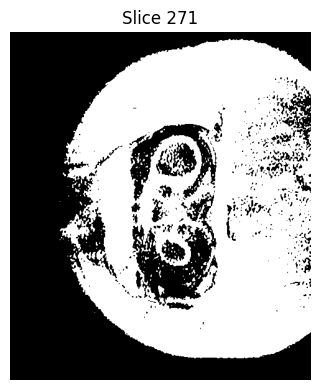

In [9]:
plot_slices(ix_start = 271, ix_end = 272, images_per_row = 2, 
            array = data_raw, dimension = 1)

### Load the annotated data:

In [10]:
file_path = 'DIRU_2022_04_dog_03_E_nc/medialis/03_E_nc_med_Segmentation.seg.nrrd'
#file_path = 'DIRU_2022_04_dog_03_E_nc/medialis_test/03_E_nc_med_Segmentation_test.seg.nrrd'

In [11]:
# Load the NRRD file
data, header = nrrd.read(file_path)

# Create a NIfTI image
img = nib.Nifti1Image(data, np.eye(4))

# Save the image in NIfTI format
# nib.save(img, 'output.nii.gz')

In [12]:
data = img.get_fdata()

In [13]:
data.shape

(4, 560, 560, 484)

### Choose the channel that contains the annotated meniscus and the background data:

In [14]:
data_ex = data[0, :, :, :]
#data_ex = data[ :, :, :]

In [15]:
data_ex.shape

(560, 560, 484)

### Choose appropriate 2-dimensional slices out of the 3-dimensional data where the annotated meniscus is visible:
The data is three-dimensional, for a start I choose to work with two dimensional data. I therefore choose some slices out of the 3-dimensional data where the meniscus is recognizable (due to annotation) in the coronal view.

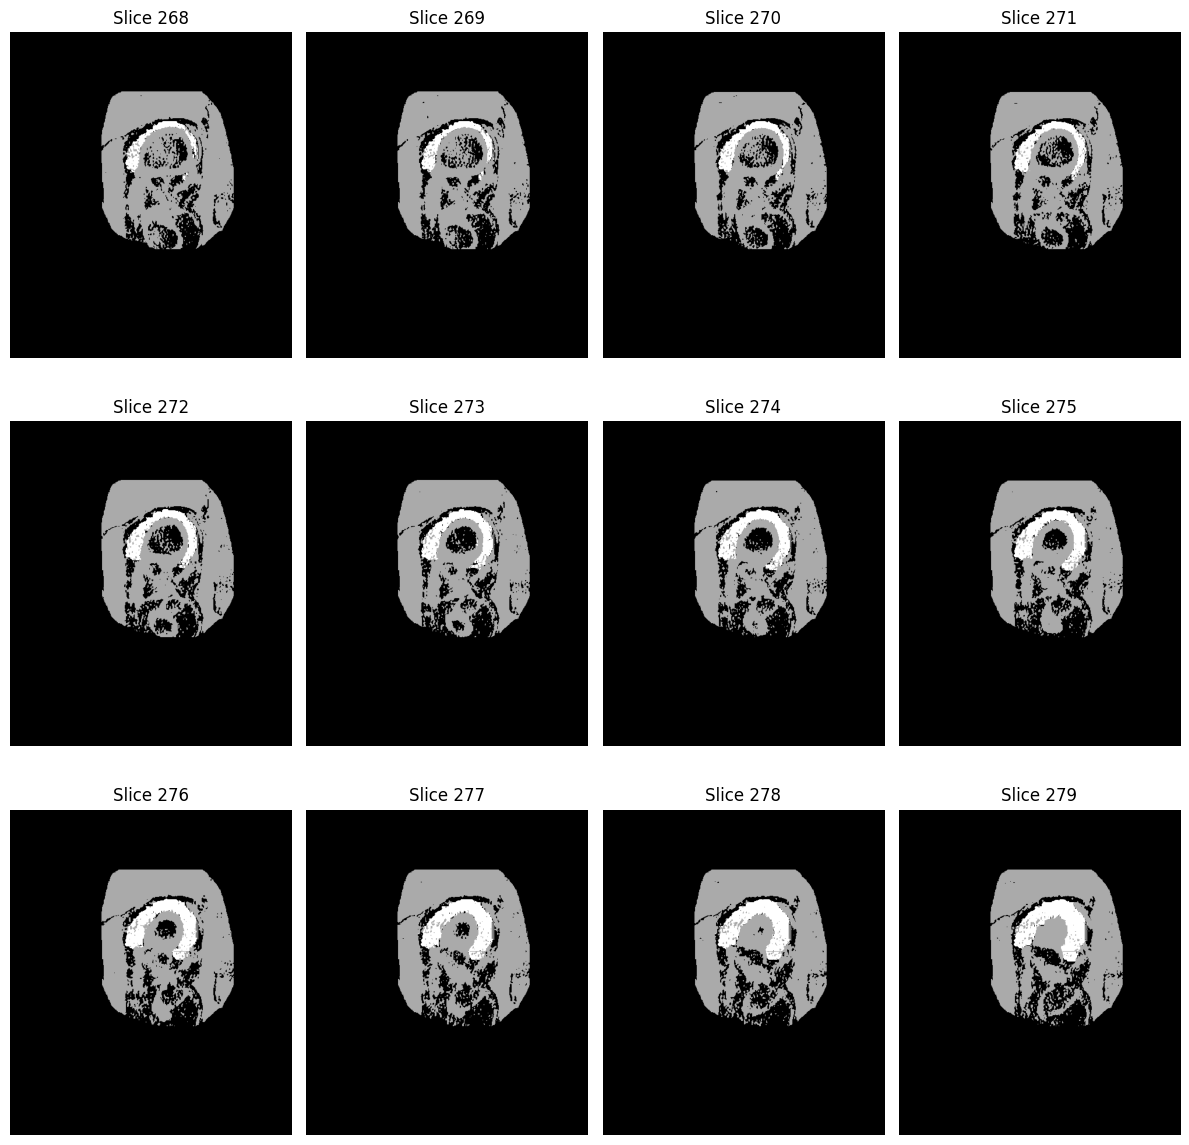

In [16]:
plot_slices(ix_start = 268, ix_end = 280, images_per_row = 4, 
            array = data_ex, dimension = 1)

## Experiment:
 Training on regular croissant shape and testing on three different cases: One similar to the training shape and two that are deviating significantly from the regualar croissant shape to see how the algorithm copes with that.

### Choose slice from the middle with a nice croissant shape for training:

In [17]:
np.unique(data_ex[:, 281, :], return_counts=True)

(array([0., 2., 3.]), array([228041,  36988,   6011]))

In [18]:
# Choose a slice from the middle: 
example_slice = data_ex[:, 281, :].copy()

In [19]:
np.unique(example_slice)

array([0., 2., 3.])

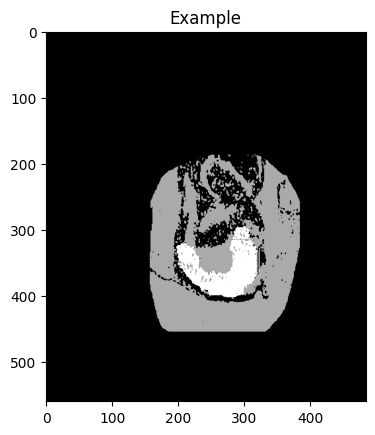

In [20]:
plt.imshow(example_slice, cmap='gray')
plt.title('Example')
plt.show()

### Prepare training data:
The function prep_train_data: Makes two copies, removes the annotation from one (pixel intensities), and removes everything except the annotation from the other (labels). 

In [21]:
slice_train, labels_train = prep_train_data(example_slice)

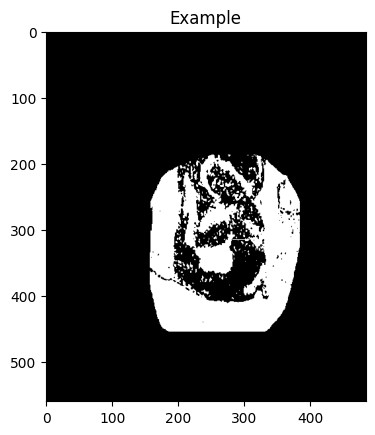

In [22]:
plt.imshow(slice_train, cmap='gray')
plt.title('Example')
plt.show()

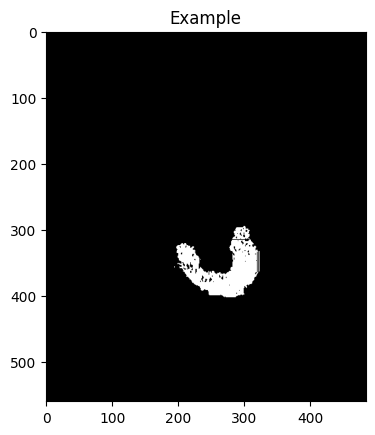

In [23]:
plt.imshow(labels_train, cmap='gray')
plt.title('Example')
plt.show()

In [24]:
print(np.unique(slice_train))
print(np.unique(labels_train))

[0. 1.]
[0. 1.]


### Choose one slice from the middle (with a regular croissant shape) and fringe slices where the croissant shape of the meniscus is less regular:

In [25]:
example_slice_0 = data_ex[:, 280, :].copy()

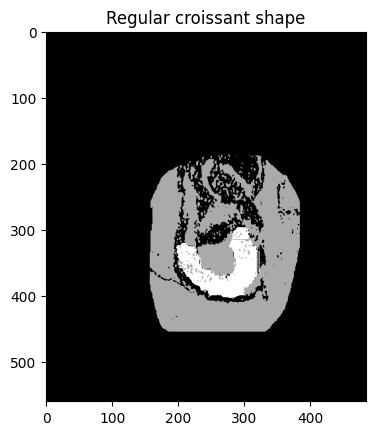

In [26]:
plt.imshow(example_slice_0, cmap='gray')
plt.title('Regular croissant shape')
plt.show()

In [27]:
example_slice_1 = data_ex[:, 285, :].copy()
np.unique(example_slice_1)

array([0., 2., 3.])

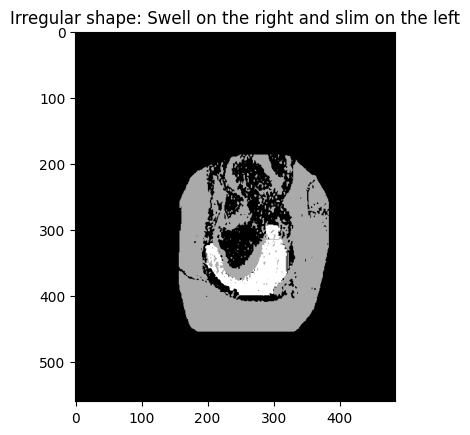

In [28]:
plt.imshow(example_slice_1, cmap='gray')
plt.title('Irregular shape: Swell on the right and slim on the left')
plt.show()

In [29]:
slice_test_1 = prep_test_data(example_slice_1)

In [30]:
example_slice_2 = data_ex[:, 270, :].copy()

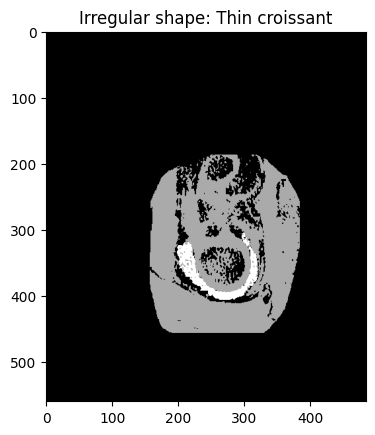

In [31]:
plt.imshow(example_slice_2, cmap='gray')
plt.title('Irregular shape: Thin croissant')
plt.show()

### Prepare test data:
The function prep_test_data removes the annotation (by setting its values to 0) and and sets the rest of the values to 1 or 0.

In [32]:
slice_test_0 = prep_test_data(example_slice_0)
slice_test_1 = prep_test_data(example_slice_1)
slice_test_2 = prep_test_data(example_slice_2)

#### Prepare training data for use with pretrained, frozen convolutional network:
Only works with 3-channel data. If it's grayscale data, just stack the image 3 times using the function `grayscale_to_rgb()`.

In [33]:
img = grayscale_to_rgb(slice_train)
#img = grayscale_to_rgb(slice_train)
#img = grayscale_to_rgb(slice_test_t)

### Extract the features using convolutional filters extracted from a VGG16

In [34]:
#create the classifier
clf = RandomForestClassifier(random_state=0)

Image input scales:
[(560, 484), (280, 242), (140, 121)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


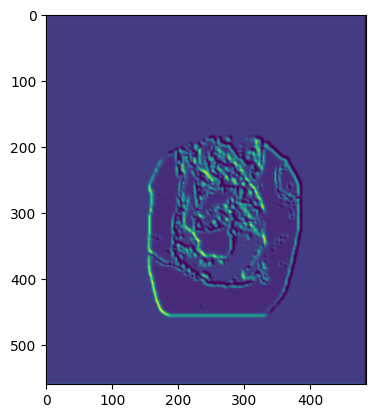

In [35]:
# create feature extractor and apply 
shapes = []
for i in [1,2,4]:
    shapes.append((int(img.shape[0]/i),(int(img.shape[1]/i))))
print("Image input scales:")
print(shapes)
models = init_VGG16_pyramid(shapes)
features = fd_VGG16_pyramid(img,models,shapes)
# plot example filter response
plt.imshow(features[:,:,100])
plt.show()

### Prepare output from the convolutional network for use with random forest:

In [36]:
# Flatten the image (combine first two dimensions: 560 * 484 = 271,040 pixels)
X = features.reshape(-1, 192)  # Shape: (271040, 192)
# Flatten the labels
y = labels_train.ravel()  # Shape: (271040,)

### Train the random forest classifier:

In [37]:
clf.fit(X, y)

RandomForestClassifier(random_state=0)

### Test classification algorithm with test slice 0 (with the regular croissant shape):

Image input scales:
[(560, 484), (280, 242), (140, 121)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


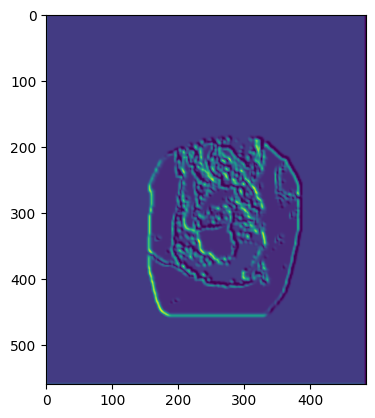

In [38]:
# Prepare test data for use with the convolutional network:
img_test_0 = grayscale_to_rgb(slice_test_0)
# create feature extractor and apply 
shapes = []
for i in [1,2,4]:
    shapes.append((int(img_test_0.shape[0]/i),(int(img_test_0.shape[1]/i))))
print("Image input scales:")
print(shapes)
models = init_VGG16_pyramid(shapes)
features_test_0 = fd_VGG16_pyramid(img_test_0,models,shapes)
# plot example filter response
plt.imshow(features_test_0[:,:,100])
plt.show()

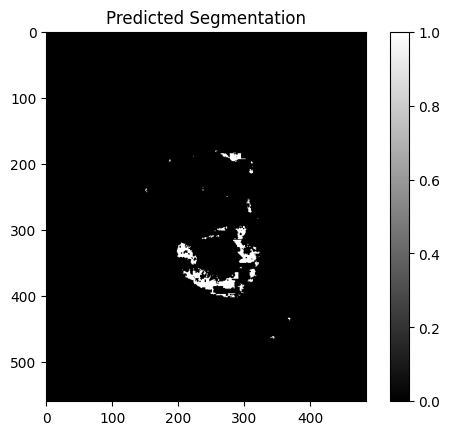

In [39]:
# Flatten the image (combine first two dimensions: 560 * 484 = 271,040 pixels)
X_test_0 = features_test_0.reshape(-1, 192)  # Shape: (271040, 192)
# Use the trained random forest classifier to make predictions:
predictions_0 = clf.predict(X_test_0)
# Assuming `predictions` is the result from your classifier, and it's a 1D array
# of shape (271040,), corresponding to (560 * 484)
predictions_reshaped_0 = predictions_0.reshape(560, 484)

# Plot the reshaped predictions
plt.imshow(predictions_reshaped_0, cmap='gray')
plt.title('Predicted Segmentation')
plt.colorbar()  # Optional: Add a colorbar
plt.show()

### Test classification algorithm with test slices 1 and 2 (less regular croissant shape):

Image input scales:
[(560, 484), (280, 242), (140, 121)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


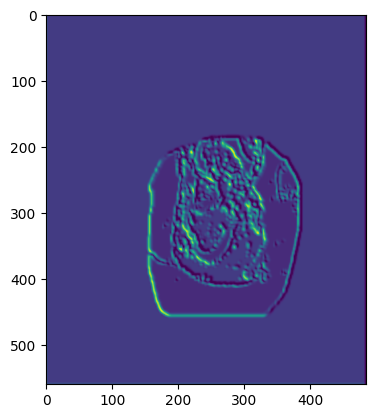

In [40]:
# Prepare test data for use with the convolutional network:
img_test_1 = grayscale_to_rgb(slice_test_1)
# create feature extractor and apply 
shapes = []
for i in [1,2,4]:
    shapes.append((int(img_test_1.shape[0]/i),(int(img_test_1.shape[1]/i))))
print("Image input scales:")
print(shapes)
models = init_VGG16_pyramid(shapes)
features_test_1 = fd_VGG16_pyramid(img_test_1,models,shapes)
# plot example filter response
plt.imshow(features_test_1[:,:,100])
plt.show()

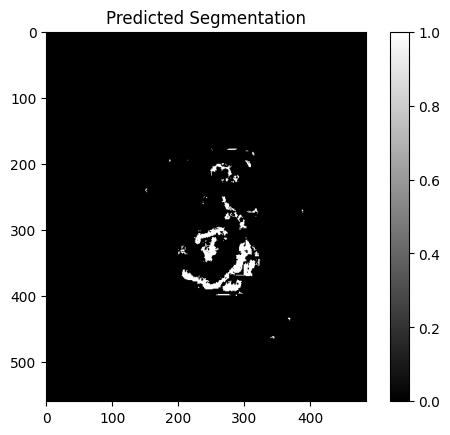

In [41]:
# Flatten the image (combine first two dimensions: 560 * 484 = 271,040 pixels)
X_test_1 = features_test_1.reshape(-1, 192)  # Shape: (271040, 192)
# Use the trained random forest classifier to make predictions:
predictions_1 = clf.predict(X_test_1)
# Assuming `predictions` is the result from your classifier, and it's a 1D array
# of shape (271040,), corresponding to (560 * 484)
predictions_reshaped_1 = predictions_1.reshape(560, 484)

# Plot the reshaped predictions
plt.imshow(predictions_reshaped_1, cmap='gray')
plt.title('Predicted Segmentation')
plt.colorbar()  # Optional: Add a colorbar
plt.show()

Image input scales:
[(560, 484), (280, 242), (140, 121)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


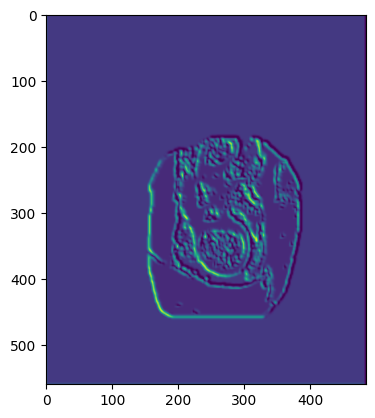

In [42]:
# Prepare test data for use with the convolutional network:
img_test_2 = grayscale_to_rgb(slice_test_2)
# create feature extractor and apply 
shapes = []
for i in [1,2,4]:
    shapes.append((int(img_test_2.shape[0]/i),(int(img_test_2.shape[1]/i))))
print("Image input scales:")
print(shapes)
models = init_VGG16_pyramid(shapes)
features_test_2 = fd_VGG16_pyramid(img_test_2,models,shapes)
# plot example filter response
plt.imshow(features_test_2[:,:,100])
plt.show()

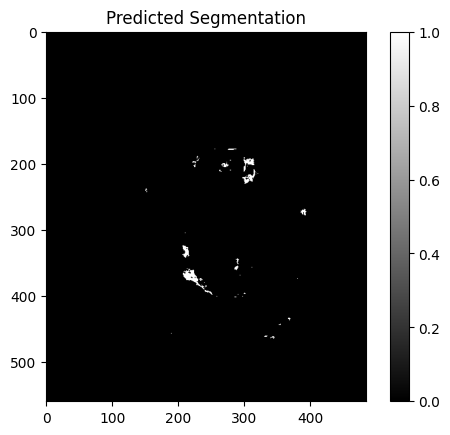

In [43]:
# Flatten the image (combine first two dimensions: 560 * 484 = 271,040 pixels)
X_test_2 = features_test_2.reshape(-1, 192)  # Shape: (271040, 192)
# Use the trained random forest classifier to make predictions:
predictions_2 = clf.predict(X_test_2)
# Assuming `predictions` is the result from your classifier, and it's a 1D array
# of shape (271040,), corresponding to (560 * 484)
predictions_reshaped_2 = predictions_2.reshape(560, 484)

# Plot the reshaped predictions
plt.imshow(predictions_reshaped_2, cmap='gray')
plt.title('Predicted Segmentation')
plt.colorbar()  # Optional: Add a colorbar
plt.show()

### Conclusion: Test result on the regular croissant shape resulted in something ressembling vaguely a croissant shape, testing on the fringe cases failed completely.